## Training, Autograd

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((.5), (.5))
    ]
)

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Model for just the logits, no softmax
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

# Loss
criterion = nn.CrossEntropyLoss()

# Fetch data
images, labels = next(iter(trainloader))

# Flatten
images = images.view(images.shape[0], -1)

# Forward pass to extract the logits
logits = model(images)
# Calculate the loss with logits and labels
loss = criterion(logits, labels)
print(loss)

tensor(2.3164, grad_fn=<NllLossBackward>)


## Loss and Autograd

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images) # log probabilities
loss = criterion(logps, labels)

print('before a round', model[0].weight.grad)
loss.backward()
print('after a round', model[0].weight.grad)

before a round None
after a round tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        ...,
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008]])


## Optimizer to update the weights

In [ ]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.01)

print('Initial Weights', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784) # It is resize_(), not resize()

# Clear the gradients or else gradients from previous steps will accumulate
optimizer.zero_grad()

# Forward pass
outputs = model.forward(images)
loss = criterion(outputs, labels)
# Backwards pass
loss.backward()
print('Gradient - ', model[0].weight.grad)
# Update the model
optimizer.step()
print('Updated Weights - ', model[0].weight)

Initial Weights Parameter containing:
tensor([[-0.0229,  0.0031,  0.0286,  ..., -0.0038,  0.0183,  0.0106],
        [ 0.0200,  0.0020,  0.0036,  ...,  0.0140,  0.0335, -0.0038],
        [-0.0023, -0.0030,  0.0106,  ..., -0.0171,  0.0147,  0.0160],
        ...,
        [-0.0270,  0.0246,  0.0218,  ...,  0.0025, -0.0345,  0.0061],
        [ 0.0084, -0.0081,  0.0132,  ..., -0.0091,  0.0287, -0.0109],
        [-0.0077,  0.0304,  0.0047,  ...,  0.0343,  0.0254,  0.0303]],
       requires_grad=True)
Gradient -  tensor([[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]])
Updated Weights -  Parameter containing:
tensor([[-0.0229,  0.0031,  0.0286,  ..., -0.0038,

## Training Process

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten 
        images = images.view(images.shape[0], -1)
        # Clearing gradients
        optimizer.zero_grad()
        # Forward
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        # Update weights
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss / len(trainloader)}")

Training loss: 1.8996283100612128
Training loss: 0.8511095293549332
Training loss: 0.5220248017992292
Training loss: 0.42931237453018933
Training loss: 0.3863604827952792


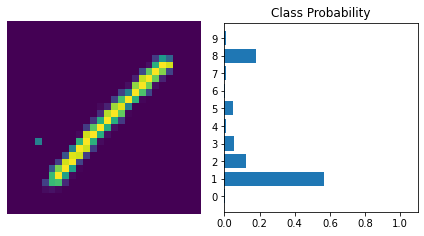

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Credits to this function
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
image = images[0].view(1, 784)

# Gradients are not needed. Turn off to speed up
with torch.no_grad():
    logps = model.forward(image)
# We need exp(log probabilities) for getting softmax probabilities
ps = torch.exp(logps)
view_classify(image.view(1, 28, 28), ps)